# Classificação de Tomates com ResNet50

## Importação das bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model

## Abertura e pré-processamento das imagens

In [3]:
train_data_dir = 'Tomate/train'
test_data_dir = 'Tomate/val'

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 7000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


## Configurando, compilando e executando o modelo

In [36]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    "best_modelResNet.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=500,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/500
219/219 [==============================] - 146s 649ms/step - loss: 1.7035 - accuracy: 0.5130 - val_loss: 24.8639 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to best_modelResNet.h5
Epoch 2/500
219/219 [==============================] - 142s 648ms/step - loss: 0.3708 - accuracy: 0.8885 - val_loss: 30.2577 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/500
219/219 [==============================] - 143s 652ms/step - loss: 0.3165 - accuracy: 0.9190 - val_loss: 13.7723 - val_accuracy: 0.0993

Epoch 00003: val_accuracy did not improve from 0.10000
Epoch 4/500
219/219 [==============================] - 140s 638ms/step - loss: 0.2080 - accuracy: 0.9454 - val_loss: 6.5529 - val_accuracy: 0.1880

Epoch 00004: val_accuracy improved from 0.10000 to 0.18800, saving model to best_modelResNet.h5
Epoch 5/500
219/219 [==============================] - 137s 623ms/step - loss: 0.1602 - accuracy: 0.9589 -

## Gráficos de treinamento e validação

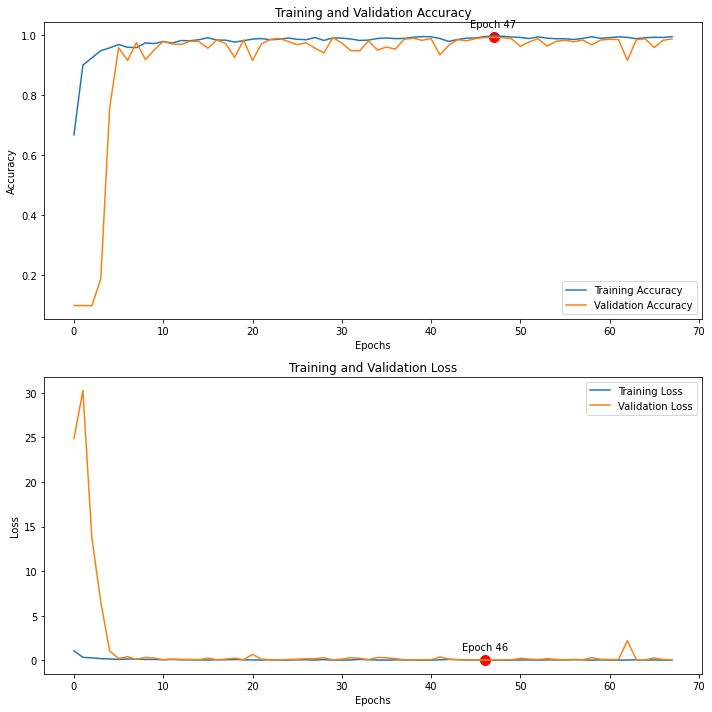

In [37]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sns.lineplot(data=history.history["accuracy"], label="Training Accuracy")
sns.lineplot(data=history.history["val_accuracy"], label="Validation Accuracy")
best_val_acc_epoch = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
plt.scatter([best_val_acc_epoch], [history.history["val_accuracy"][best_val_acc_epoch]], c='red', marker='o', s=100)
plt.annotate(f'Epoch {best_val_acc_epoch}', (best_val_acc_epoch, history.history["val_accuracy"][best_val_acc_epoch]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=history.history["loss"], label="Training Loss")
sns.lineplot(data=history.history["val_loss"], label="Validation Loss")
best_val_loss_epoch = history.history["val_loss"].index(min(history.history["val_loss"]))
plt.scatter([best_val_loss_epoch], [history.history["val_loss"][best_val_loss_epoch]], c='red', marker='o', s=100)
plt.annotate(f'Epoch {best_val_loss_epoch}', (best_val_loss_epoch, history.history["val_loss"][best_val_loss_epoch]), textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Análise do modelo

Found 10000 images belonging to 10 classes.


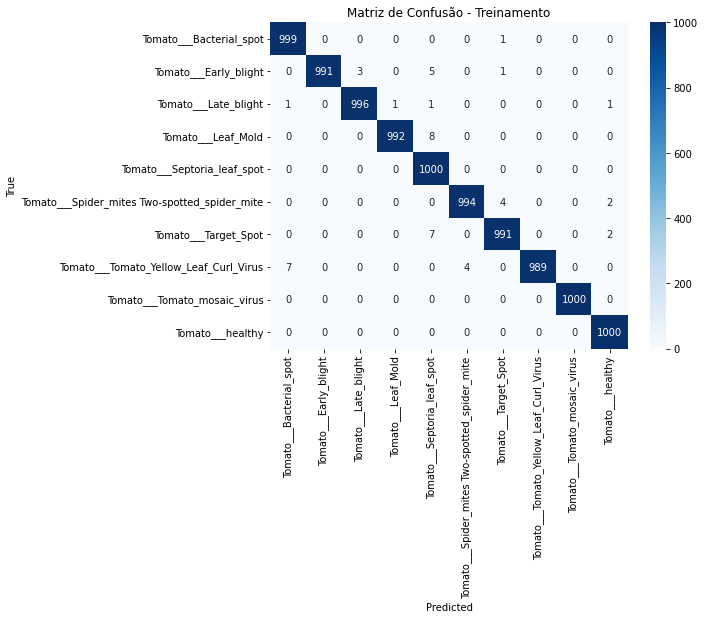


Métricas de Avaliação - Treinamento:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.99      1.00      1.00      1000
                        Tomato___Early_blight       1.00      0.99      1.00      1000
                         Tomato___Late_blight       1.00      1.00      1.00      1000
                           Tomato___Leaf_Mold       1.00      0.99      1.00      1000
                  Tomato___Septoria_leaf_spot       0.98      1.00      0.99      1000
Tomato___Spider_mites Two-spotted_spider_mite       1.00      0.99      0.99      1000
                         Tomato___Target_Spot       0.99      0.99      0.99      1000
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99      1000
                 Tomato___Tomato_mosaic_virus       1.00      1.00      1.00      1000
                             Tomato___healthy       1.00      1.00      1.00      1000

   

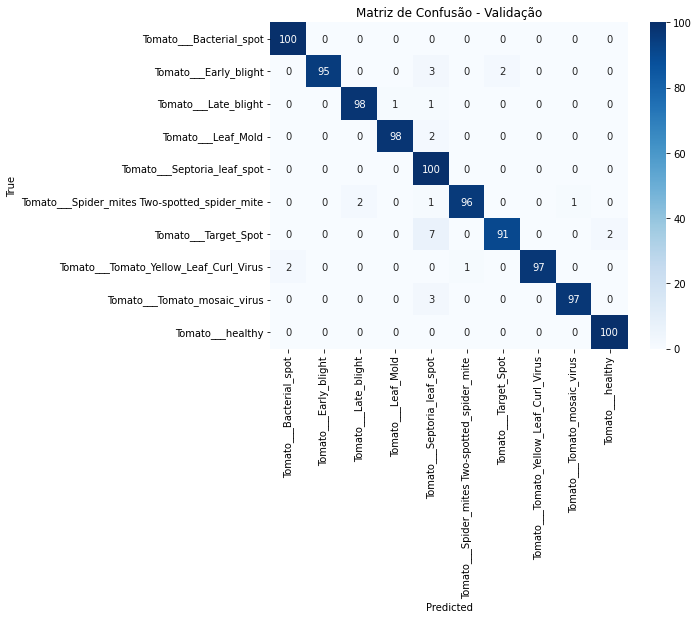


Métricas de Avaliação - Validação:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.98      1.00      0.99       100
                        Tomato___Early_blight       1.00      0.95      0.97       100
                         Tomato___Late_blight       0.98      0.98      0.98       100
                           Tomato___Leaf_Mold       0.99      0.98      0.98       100
                  Tomato___Septoria_leaf_spot       0.85      1.00      0.92       100
Tomato___Spider_mites Two-spotted_spider_mite       0.99      0.96      0.97       100
                         Tomato___Target_Spot       0.98      0.91      0.94       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.97      0.98       100
                 Tomato___Tomato_mosaic_virus       0.99      0.97      0.98       100
                             Tomato___healthy       0.98      1.00      0.99       100

     

In [6]:
def evaluate_model(data_dir, model_path, data_type):
    image_size = (224, 224)
    batch_size = 32

    model = load_model(model_path)

    data_datagen = ImageDataGenerator(rescale=1/255.0)

    data_gen = data_datagen.flow_from_directory(
        data_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    y_data_pred = model.predict(data_gen)
    y_data_true = data_gen.classes
    data_confusion = confusion_matrix(y_data_true, np.argmax(y_data_pred, axis=1))
    class_names = list(data_gen.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(data_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Matriz de Confusão - {data_type}')
    plt.show()

    data_classification_report = classification_report(y_data_true, np.argmax(y_data_pred, axis=1), target_names=class_names)
    print(f"\nMétricas de Avaliação - {data_type}:")
    print(data_classification_report)
    
    accuracy = np.mean(np.argmax(y_data_pred, axis=1) == y_data_true)
    
    accuracy_std = np.std(np.argmax(y_data_pred, axis=1) == y_data_true)
    
    print(f"Acurácia ± desvio padrão - {data_type}: {accuracy:.2f} ± {accuracy_std:.2f}")

model_path = 'best_modelResNet.h5'
train_data_dir = 'Tomate/train'
val_data_dir = 'Tomate/val'

evaluate_model(train_data_dir, model_path, 'Treinamento')
evaluate_model(val_data_dir, model_path, 'Validação')


## Exibir exemplos de imagens do conjunto de treinamento e validação

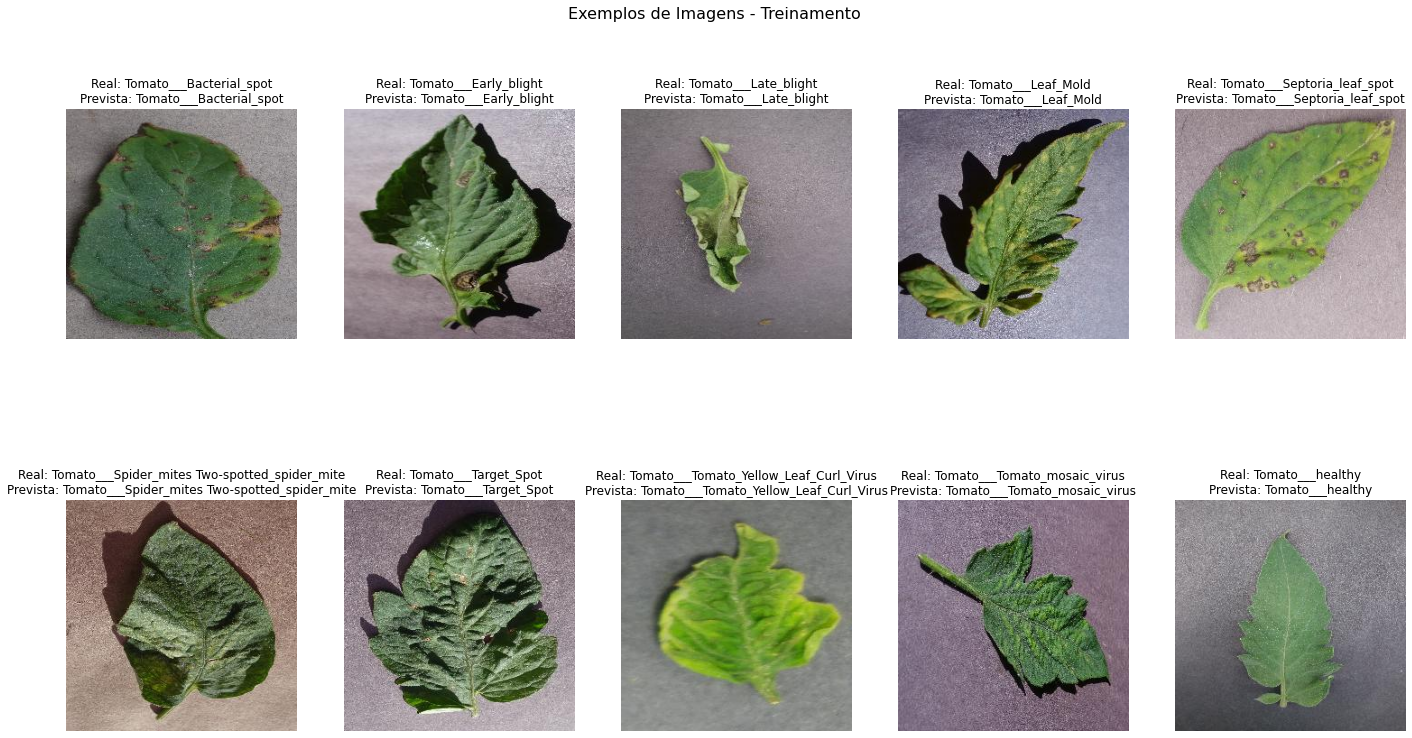

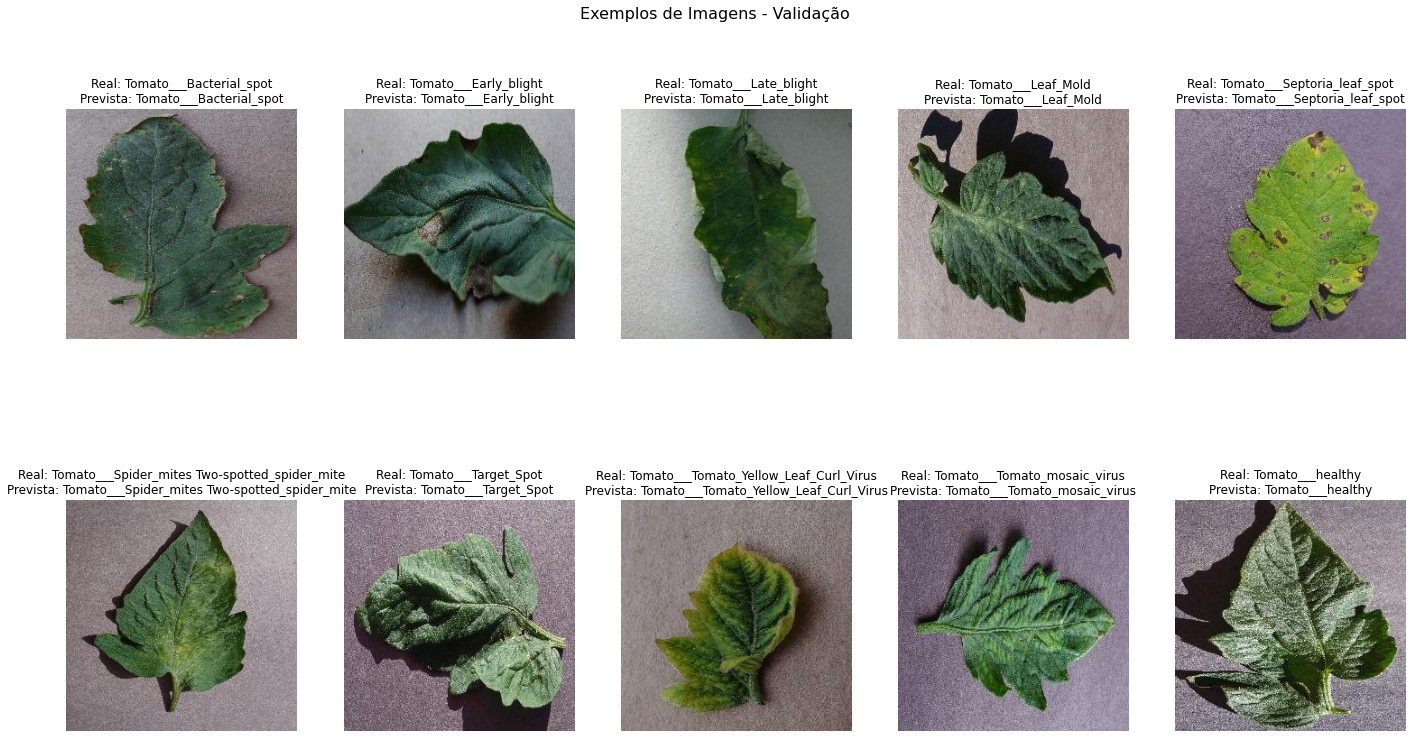

In [7]:
def plot_image_examples(class_names, data_dir, title):
    fig, axes = plt.subplots(2, 5, figsize=(24, 12))
    fig.suptitle(title, fontsize=16)

    for i, class_name in enumerate(class_names):
        class_directory = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_directory)

        if len(image_files) > 0:
            img_file = random.choice(image_files)
            img_path = os.path.join(class_directory, img_file)

            img = Image.open(img_path)
            axes[i // 5, i % 5].imshow(img)
            axes[i // 5, i % 5].axis('off')

            img = img.resize((224, 224))
            img = img.convert('RGB')
            img = img.resize((224, 224))
            img = np.array(img) / 255.0
            img = img.reshape(1, 224, 224, 3)
            predicted_class = np.argmax(model.predict(img))
            predicted_label = class_names[predicted_class]

            if predicted_label != class_name:
                title_color = 'red'
            else:
                title_color = 'black'

            axes[i // 5, i % 5].set_title(f'Real: {class_name}\nPrevista: {predicted_label}', color=title_color)
        else:
            print(f"Nenhuma imagem encontrada para a classe {class_name}")
            axes[i // 5, i % 5].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()

class_names = list(train_gen.class_indices.keys())

plot_image_examples(class_names, train_data_dir, "Exemplos de Imagens - Treinamento")
plot_image_examples(class_names, test_data_dir, "Exemplos de Imagens - Validação")


## Classificação de uma imagem desconhecida pelo conjunto de imagens
A imagem a seguir foi retirada do artigo Estratégias para o desenvolvimento de resistência ampla e durável em Solanum (secção Lycopersicon) a Potyvirus e Tospovirus de Resende et. all. 

No momento, para executar, execute primeiro as células de código 1 e 2 e em seguida toda a análise do modelo. 

Probabilidade da classe Tomato___Bacterial_spot: 0.00
Probabilidade da classe Tomato___Early_blight: 0.00
Probabilidade da classe Tomato___Late_blight: 0.00
Probabilidade da classe Tomato___Leaf_Mold: 0.00
Probabilidade da classe Tomato___Septoria_leaf_spot: 0.00
Probabilidade da classe Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Probabilidade da classe Tomato___Target_Spot: 0.00
Probabilidade da classe Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Probabilidade da classe Tomato___Tomato_mosaic_virus: 1.00
Probabilidade da classe Tomato___healthy: 0.00


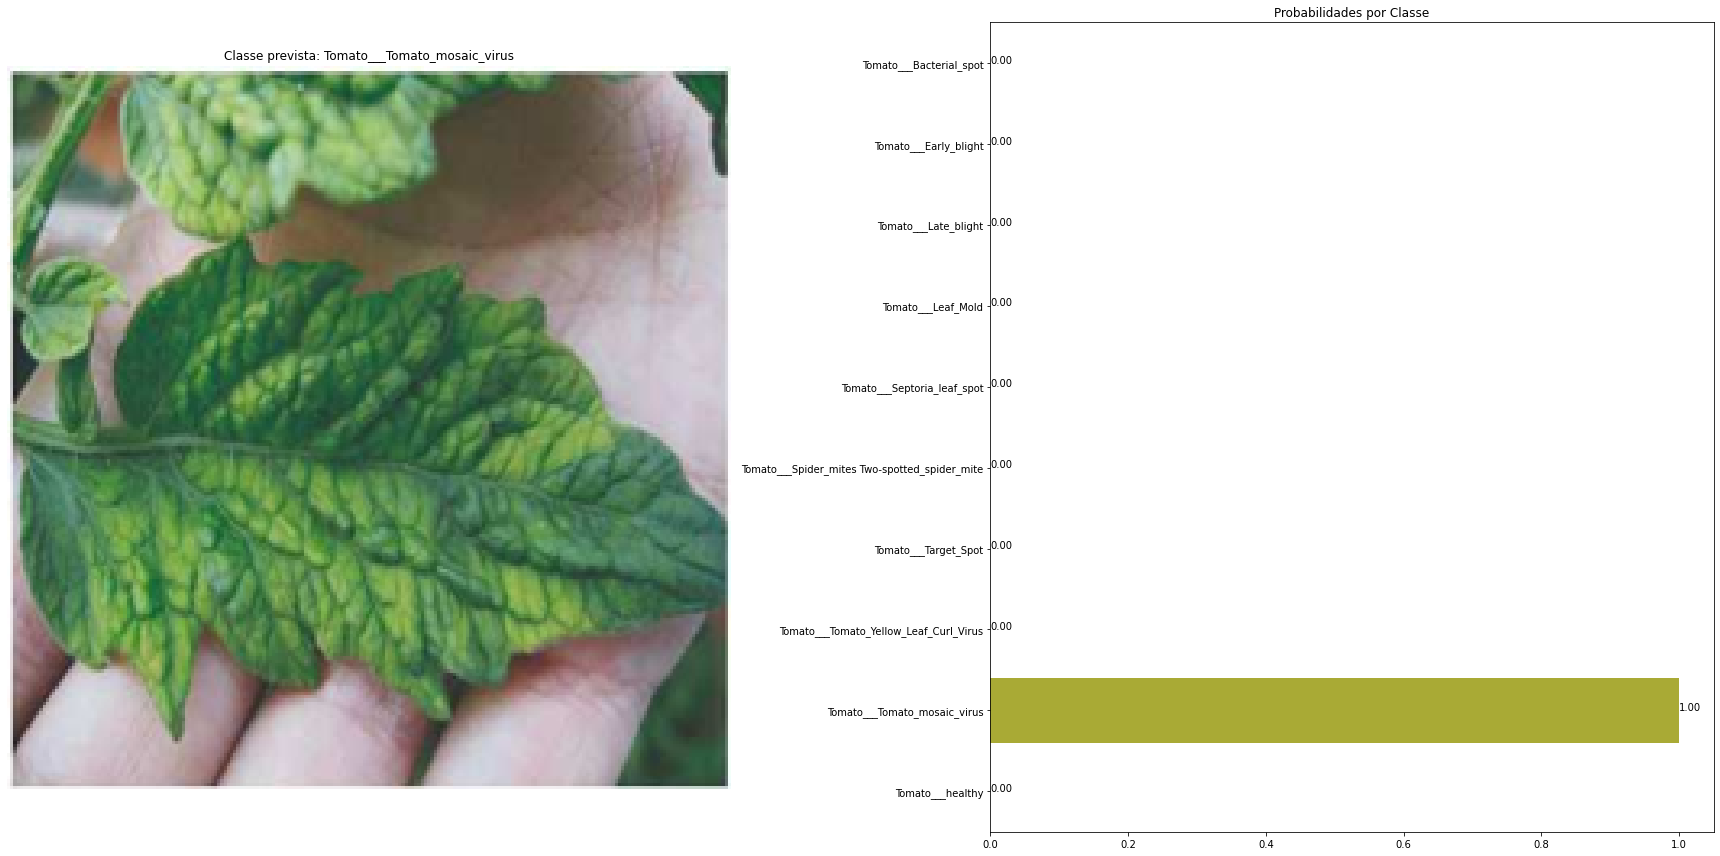

In [8]:
def classify_single_image(image_path, model, class_names):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = img.convert('RGB')
    img = np.array(img) / 255.0
    img = img.reshape(1, 224, 224, 3)

    predictions = model.predict(img)

    predicted_class = np.argmax(predictions)
    predicted_label = class_names[predicted_class]

    for i in range(len(class_names)):
        probability = predictions[0][i]
        formatted_probability = "{:.2f}".format(probability)
        print(f'Probabilidade da classe {class_names[i]}: {formatted_probability}')

    plt.figure(figsize=(24, 12))
    plt.subplot(1, 2, 1)  
    plt.imshow(img[0])
    plt.axis('off')
    plt.title(f'Classe prevista: {predicted_label}')

    probabilities = [predictions[0][i] for i in range(len(class_names))]
    
    plt.subplot(1, 2, 2)  
    ax = sns.barplot(x=probabilities, y=class_names, orient='h')
    
    plt.title('Probabilidades por Classe')
    plt.tight_layout()

    for p in ax.patches:
        width = p.get_width()
        plt.text(width, p.get_y() + p.get_height() / 2, f'{width:.2f}', ha="left")

    plt.show()

    return predicted_label

model = load_model("best_modelResNet.h5")
image_path = 'mosaico.png'
predicted_class = classify_single_image(image_path, model, class_names)

Demais imagens coletadas do Google Imagens

Probabilidade da classe Tomato___Bacterial_spot: 0.00
Probabilidade da classe Tomato___Early_blight: 0.00
Probabilidade da classe Tomato___Late_blight: 0.00
Probabilidade da classe Tomato___Leaf_Mold: 0.00
Probabilidade da classe Tomato___Septoria_leaf_spot: 1.00
Probabilidade da classe Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Probabilidade da classe Tomato___Target_Spot: 0.00
Probabilidade da classe Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Probabilidade da classe Tomato___Tomato_mosaic_virus: 0.00
Probabilidade da classe Tomato___healthy: 0.00


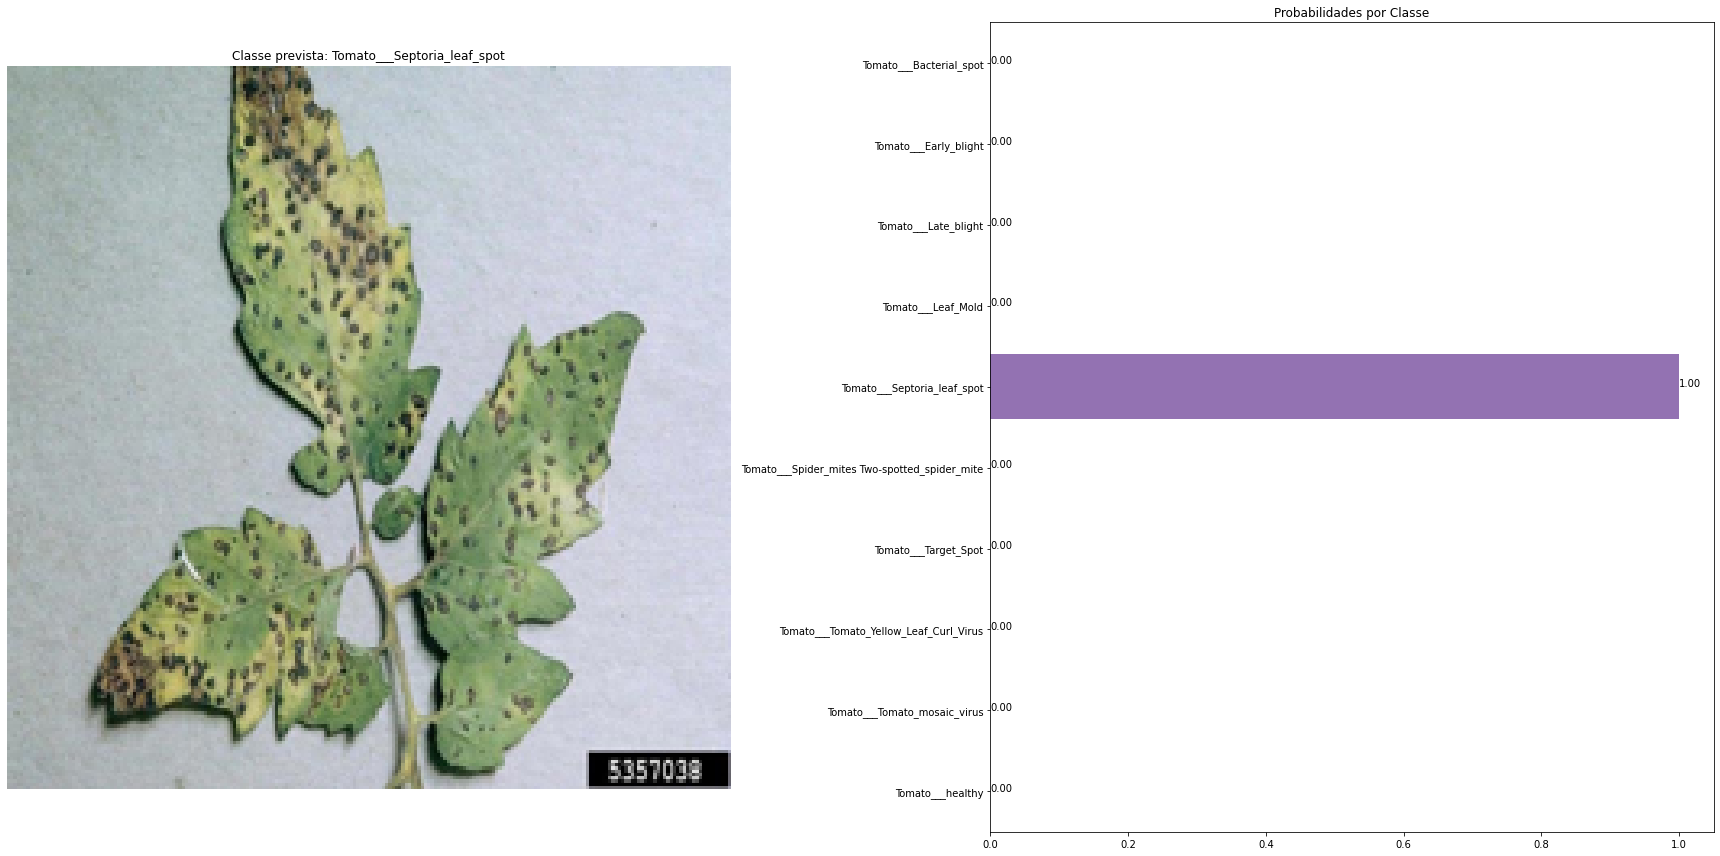

In [16]:
image_path = 'septoriose.jpg'
predicted_class = classify_single_image(image_path, model, class_names)

Probabilidade da classe Tomato___Bacterial_spot: 0.00
Probabilidade da classe Tomato___Early_blight: 0.00
Probabilidade da classe Tomato___Late_blight: 0.00
Probabilidade da classe Tomato___Leaf_Mold: 0.00
Probabilidade da classe Tomato___Septoria_leaf_spot: 1.00
Probabilidade da classe Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Probabilidade da classe Tomato___Target_Spot: 0.00
Probabilidade da classe Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Probabilidade da classe Tomato___Tomato_mosaic_virus: 0.00
Probabilidade da classe Tomato___healthy: 0.00


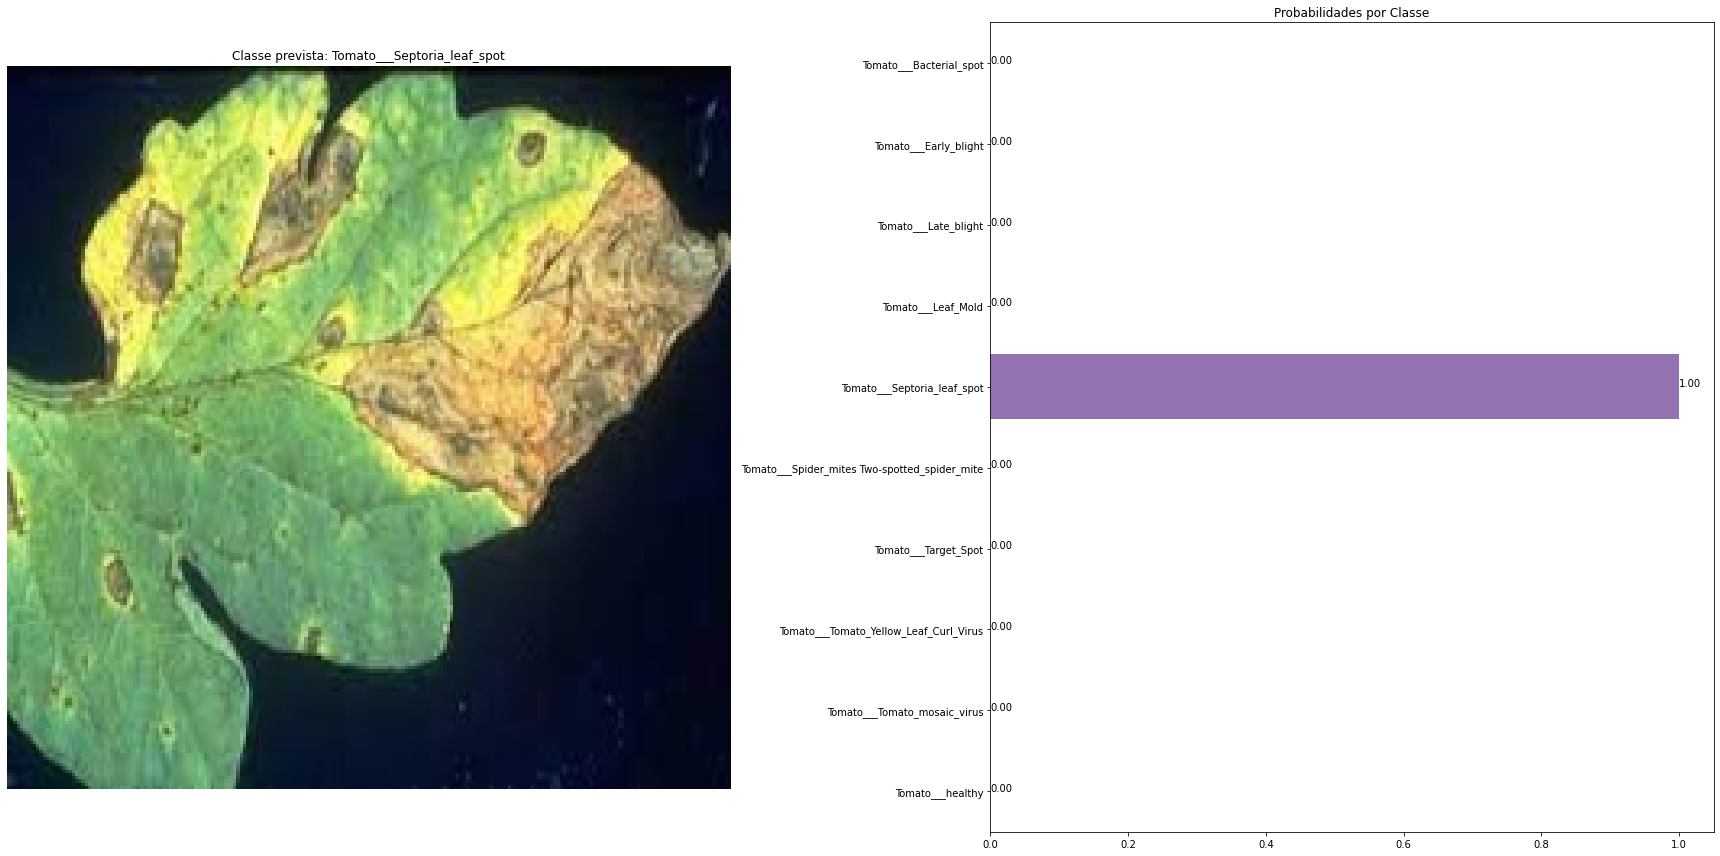

In [17]:
image_path = 'septoriose1.jpeg'
predicted_class = classify_single_image(image_path, model, class_names)

Probabilidade da classe Tomato___Bacterial_spot: 0.00
Probabilidade da classe Tomato___Early_blight: 1.00
Probabilidade da classe Tomato___Late_blight: 0.00
Probabilidade da classe Tomato___Leaf_Mold: 0.00
Probabilidade da classe Tomato___Septoria_leaf_spot: 0.00
Probabilidade da classe Tomato___Spider_mites Two-spotted_spider_mite: 0.00
Probabilidade da classe Tomato___Target_Spot: 0.00
Probabilidade da classe Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00
Probabilidade da classe Tomato___Tomato_mosaic_virus: 0.00
Probabilidade da classe Tomato___healthy: 0.00


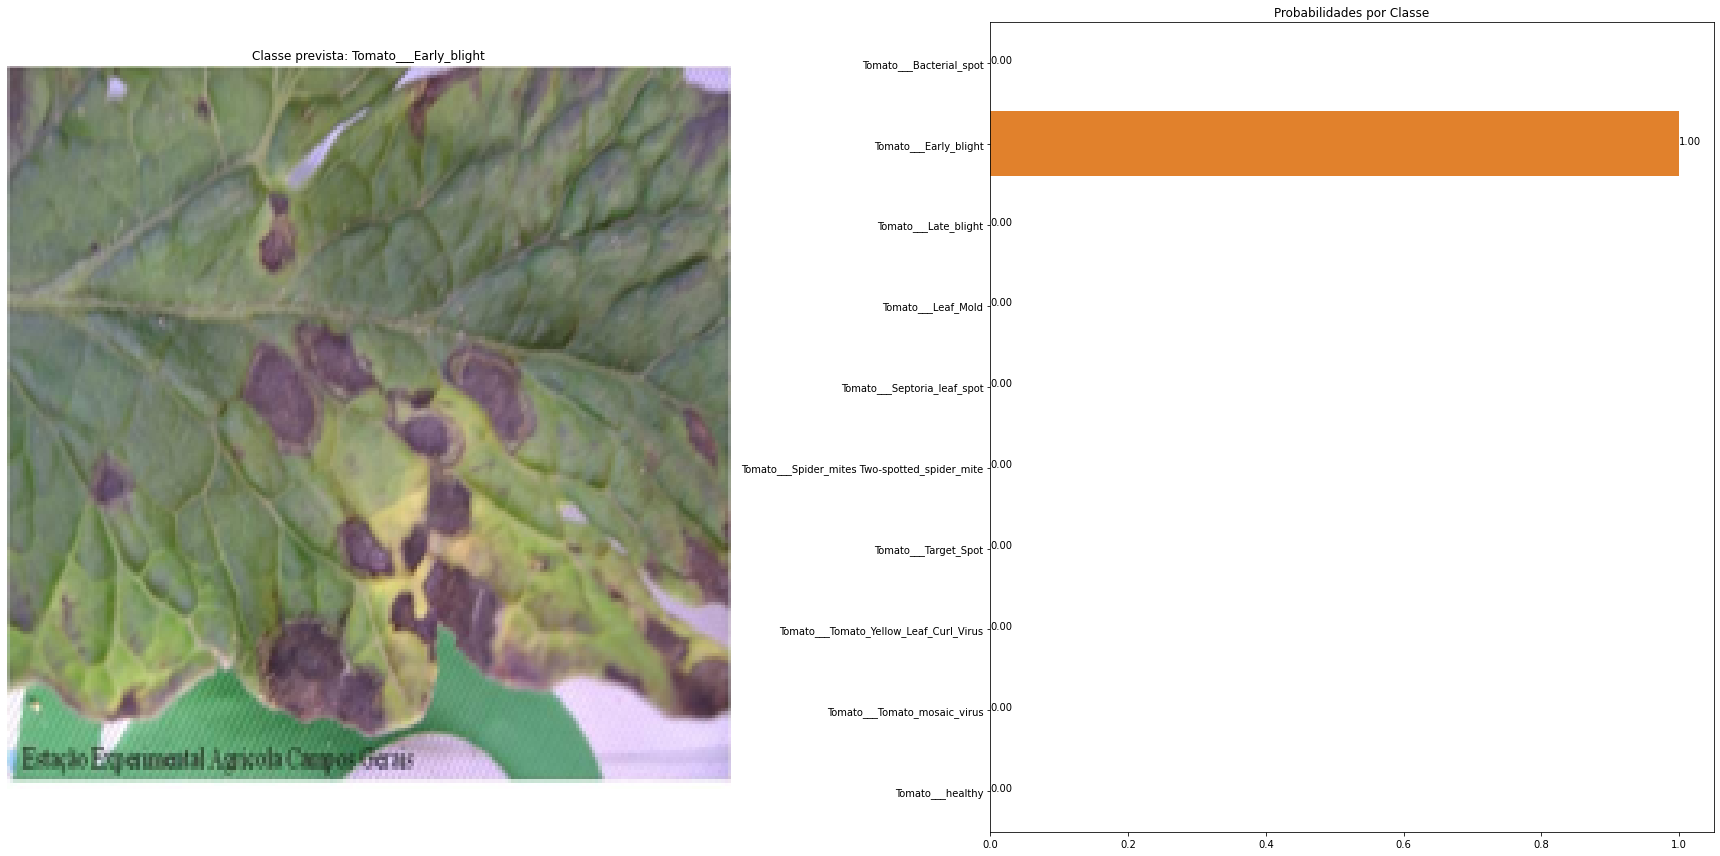

In [26]:
image_path = 'early blight.jpg'
predicted_class = classify_single_image(image_path, model, class_names)